# Polynomial Regression (Polynomial Regression) for Wine Data

**Objective**
- Predict standard variables (e.g. `quality`) from typical wines.

- Apply **Polynomial Regression** with standard procedure: preprocessing → choose polynomial degree (CV) → train → evaluate → analytical residuals → conclude.

**Shortcut method**
- Generate specific expression (meals 1→5) + standardize **StandardScaler**.

- Select **equals** with **K-Fold Cross Validation**.

- Evaluate with **R², MAE, MSE, RMSE**, plot **true_y vs. predicted_y** and **residue**.

- (Optional) Compare with **Ridge/Lasso** to limit overfitting.

## Shortcut theory
- **Polynomial regression**: specifically expand the **polynomial & interaction** components to \(d\), then use **OLS** (or Ridge/Lasso) to estimate the quantity.
- **StandardScaler**: Make the symbols have the same scale, stable when creating polynomials.
- **Cross-validation**: estimate the thrilling performance, used to **choose the best degree**/alpha (reduce underfit/overfit).
- **Numbers only**:
- **R²**: the ratio of the method error of \(y\) simulated explained (close to 1 is good).
- **MAE**: mean absolute error (same unit \(y\), easy to understand).
- **MSE/RMSE**: square & root mean square error; **RMSE** is sensitive to large errors (outliers).
- **Residual analysis**: residuals should be randomly distributed around 0; if there is a pattern → model does not fit / needs level adjustment, specific or regular.

In [ ]:
import os
import pandas as pd
from IPython.display import Markdown, display

# Đường dẫn file (đổi nếu cần)
CSV_PATH = r"Data/Wine_clean.csv"

df = pd.read_csv(CSV_PATH)

# Chọn target: ưu tiên 'quality', nếu không có thì lấy cột cuối
target_col = "quality" if "quality" in df.columns else df.columns[-1]
X = df.drop(columns=[target_col])
y = df[target_col]

display(Markdown(f"""
### 1) Load data & select Target
- File: `{CSV_PATH}`
- Size: **{df.shape[0]} x {df.shape[1]}**
- Target: **`{target_col}`**
- Number of features: **{X.shape[1]}**
"""))
for col in ['Unnamed: 0', 'index', 'Id', 'id']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Quick view of first 5 rows
display(df.head(5))

<>:6: SyntaxWarning: invalid escape sequence '\W'
<>:6: SyntaxWarning: invalid escape sequence '\W'
C:\Users\nguye\AppData\Local\Temp\ipykernel_15480\3480336548.py:6: SyntaxWarning: invalid escape sequence '\W'
  CSV_PATH = "E:\Wine_clean.csv"



### 1) Load data & select Target
- File: `E:\Wine_clean.csv`
- Size: **1194 x 13**
- Target: **`quality`**
- Number of features: **12**


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5
1,-0.250994,2.167738,-1.377452,0.937243,1.365747,1.133715,0.952872,0.142508,-0.938945,0.411596,-0.579638,5
2,-0.250994,1.439628,-1.155393,0.258471,0.946004,-0.000665,0.454289,0.267217,-0.484660,0.153303,-0.579638,5
3,2.076938,-1.472812,1.731370,-0.646558,-0.243268,0.226211,0.684404,0.890766,-1.241802,-0.449381,-0.579638,6
4,-0.524869,1.075573,-1.377452,-0.646558,-0.173311,-0.454417,-0.312763,0.766056,1.408196,-0.621576,-0.989805,5


## 2: Train/Test Split & Reasons
- Split **80/20** to evaluate the model on unseen data.
- Do not use all of them for training to avoid **optimistic bias**.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (955, 12)  Test shape: (239, 12)


## 3: Choose polynomial degree (degree) using K-Fold Cross-Validation
- Try **degree = 1..5** (can change).
- Pipeline: `StandardScaler → PolynomialFeatures(degree) → LinearRegression`.
- **Scoring**: R² (higher is better).
- Choose the degree with the highest average **R² CV** (balance complexity & generality).

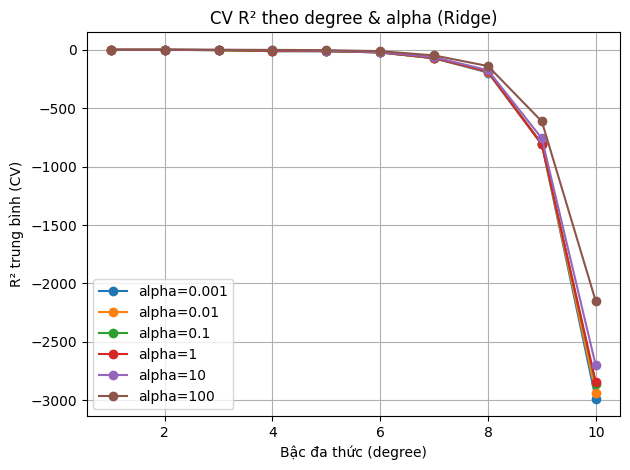

- **Best CV** → degree = **1**, alpha = **10.0**, R²(CV) ≈ **0.3686**

In [ ]:
# === Polynomial Regression (Ridge) — tune degree & alpha, report metrics, plots ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import pandas as pd
from IPython.display import Markdown, display

# -----------------------
# 1) Cross-Validation để chọn degree & alpha
# -----------------------
degrees = range(1, 11)                     # ↑ mở rộng tới 10 để bớt underfit
alphas  = [0.001, 0.01, 0.1, 1, 10, 100]   # ↑ quét alpha rộng hơn
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for d in degrees:
    for a in alphas:
        pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("poly", PolynomialFeatures(degree=d, include_bias=False)),
            ("ridge", Ridge(alpha=a, max_iter=10000))
        ])
        scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
        rows.append({
            "degree": d,
            "alpha": a,
            "mean_R2_CV": scores.mean(),
            "std_R2_CV": scores.std()
        })

cv_df = pd.DataFrame(rows)

# 2) Vẽ R² theo degree cho từng alpha (giúp nhìn xu hướng)
plt.figure()
for a in alphas:
    sub = cv_df[cv_df["alpha"] == a].sort_values("degree")
    plt.plot(sub["degree"], sub["mean_R2_CV"], marker="o", label=f"alpha={a}")
plt.xlabel("Bậc đa thức (degree)")
plt.ylabel("R² trung bình (CV)")
plt.title("CV R² theo degree & alpha (Ridge)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Chọn cấu hình tốt nhất theo R²(CV)
best_row = cv_df.iloc[cv_df["mean_R2_CV"].idxmax()]
best_degree = int(best_row["degree"])
best_alpha  = float(best_row["alpha"])
best_r2cv   = float(best_row["mean_R2_CV"])
display(Markdown(
    f"- **Best CV** → degree = **{best_degree}**, alpha = **{best_alpha}**, "
    f"R²(CV) ≈ **{best_r2cv:.4f}**"
))


## 4: Train the final model (OLS) & evaluate
- Use the optimal degree found.
- Report **R², MAE, MSE, RMSE** for **Train** and **Test**.
- Plot **true_y vs predicted_y**, **Residuals vs predicted_y**, **histogram residuals**.

## Performance after tuning degree & alpha (Ridge)

,Split,R2,MAE,MSE,RMSE
0,Train,0.3870,0.4742,0.3615,0.6012
1,Test,0.4338,0.4413,0.3258,0.5708


🔹 Model Accuracy (R² on Test): 0.4338 | degree=1, alpha=10.0


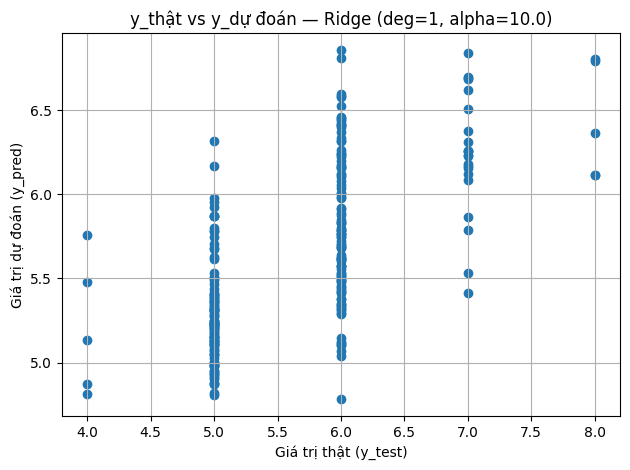

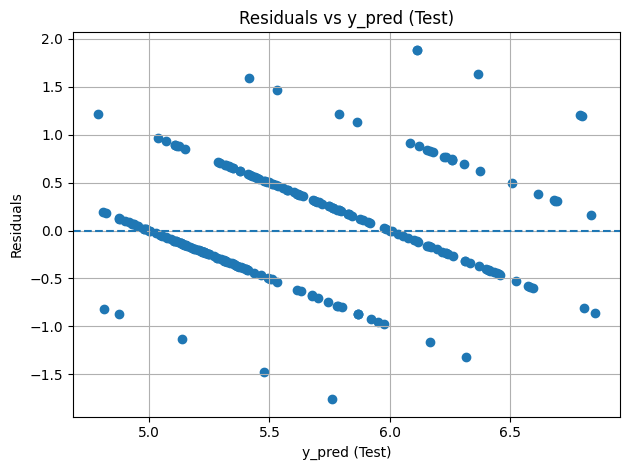

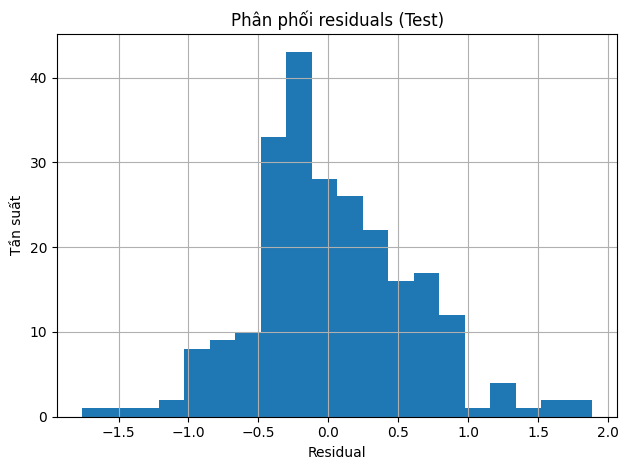

In [7]:
# -----------------------
best_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=best_degree, include_bias=False)),
    ("ridge", Ridge(alpha=best_alpha, max_iter=10000))
])
best_pipe.fit(X_train, y_train)

y_pred_train = best_pipe.predict(X_train)
y_pred_test  = best_pipe.predict(X_test)

def reg_metrics(y_true, y_pred):
    r2  = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse= np.sqrt(mse)
    return r2, mae, mse, rmse

tr_r2, tr_mae, tr_mse, tr_rmse = reg_metrics(y_train, y_pred_train)
te_r2, te_mae, te_mse, te_rmse = reg_metrics(y_test,  y_pred_test)

summary = pd.DataFrame([
    {"Split":"Train", "R2":tr_r2, "MAE":tr_mae, "MSE":tr_mse, "RMSE":tr_rmse},
    {"Split":"Test",  "R2":te_r2, "MAE":te_mae, "MSE":te_mse, "RMSE":te_rmse},
]).round(4)

display(Markdown("## Performance after tuning degree & alpha (Ridge)"))
display(summary)
print(f"🔹 Model Accuracy (R² on Test): {te_r2:.4f} | degree={best_degree}, alpha={best_alpha}")

# -----------------------
# 5) Biểu đồ chẩn đoán
# -----------------------
# y_true vs y_pred (Test)
plt.figure()
plt.scatter(y_test, y_pred_test)
plt.xlabel("Giá trị thật (y_test)")
plt.ylabel("Giá trị dự đoán (y_pred)")
plt.title(f"y_thật vs y_dự đoán — Ridge (deg={best_degree}, alpha={best_alpha})")
plt.grid(True)
plt.tight_layout()
plt.show()

# Residuals vs Predicted (Test)
residuals = y_test - y_pred_test
plt.figure()
plt.scatter(y_pred_test, residuals)
plt.axhline(0, linestyle="--")
plt.xlabel("y_pred (Test)")
plt.ylabel("Residuals")
plt.title("Residuals vs y_pred (Test)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Histogram residuals
plt.figure()
plt.hist(residuals, bins=20)
plt.xlabel("Residual")
plt.ylabel("Tần suất")
plt.title("Phân phối residuals (Test)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 5: Model coefficients
- After expanding the polynomial, the **feature/interaction combinations** will have their own coefficients.
- We print **Top coefficients by |coef|** to see the strong influencing components.

In [18]:
# Tách các bước để truy xuất tên đặc trưng sau PolynomialFeatures
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
from sklearn.linear_model import Ridge, Lasso, LinearRegression

poly = PolynomialFeatures(degree=best_degree, include_bias=False).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)

linreg = LinearRegression().fit(X_train_poly, y_train)

feature_names = poly.get_feature_names_out(X.columns)
coef = linreg.coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef,
    "abs_coefficient": np.abs(coef)
}).sort_values("abs_coefficient", ascending=False)

display(coef_df.head(30))


,feature,coefficient,abs_coefficient
11,alcohol,0.280280,0.280280
10,sulphates,0.193991,0.193991
2,volatile acidity,-0.142258,0.142258
7,total sulfur dioxide,-0.082465,0.082465
9,pH,-0.079123,0.079123
8,density,-0.068439,0.068439
3,citric acid,-0.053337,0.053337
6,free sulfur dioxide,0.051091,0.051091
0,Unnamed: 0,-0.050261,0.050261
1,fixed acidity,0.032331,0.032331


## 6: Regularization: Ridge/Lasso
- Polynomial regression is easy to **overfit** when the degree is large (many interacting features).
- Use **Ridge**/**Lasso** to penalize the coefficient magnitude → **reduce variance**, better generalization.
- Try some **alpha** and compare **R² (CV)**.

In [19]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

def cv_r2_for(model, degree, X_train, y_train, cv):
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("model", model)
    ])
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="r2")
    return scores.mean(), scores.std()

alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
rows = []

# OLS baseline
mean_cv, std_cv = cv_r2_for(LinearRegression(), best_degree, X_train, y_train, cv)
rows.append({"Model":"OLS", "Alpha":"-", "Degree":best_degree, "Mean_R2_CV":mean_cv, "Std":std_cv})

# Ridge / Lasso
for a in alphas:
    mean_cv, std_cv = cv_r2_for(Ridge(alpha=a, max_iter=10000), best_degree, X_train, y_train, cv)
    rows.append({"Model":"Ridge", "Alpha":a, "Degree":best_degree, "Mean_R2_CV":mean_cv, "Std":std_cv})
for a in alphas:
    mean_cv, std_cv = cv_r2_for(Lasso(alpha=a, max_iter=10000), best_degree, X_train, y_train, cv)
    rows.append({"Model":"Lasso", "Alpha":a, "Degree":best_degree, "Mean_R2_CV":mean_cv, "Std":std_cv})

reg_cmp = pd.DataFrame(rows).sort_values(["Model","Alpha"])
display(reg_cmp)


,Model,Alpha,Degree,Mean_R2_CV,Std
6,Lasso,0.01,1,0.366931,0.036408
7,Lasso,0.1,1,0.324031,0.015525
8,Lasso,1.0,1,-0.004049,0.003645
9,Lasso,10.0,1,-0.004049,0.003645
10,Lasso,100.0,1,-0.004049,0.003645
0,OLS,-,1,0.368236,0.037529
1,Ridge,0.01,1,0.368236,0.037528
2,Ridge,0.1,1,0.368240,0.037528
3,Ridge,1.0,1,0.368279,0.037519
4,Ridge,10.0,1,0.368575,0.037413


In [22]:
from IPython.display import Markdown, display

display(Markdown(f"""
## 7: Conclusion

**Selected Degree (CV)**: **{best_degree}**

**Final Model Performance (OLS):**
- **Train** → R² = **{tr_r2:.4f}**, MAE = **{tr_mae:.4f}**, MSE = **{tr_mse:.4f}**, RMSE = **{tr_rmse:.4f}**
- **Test** → R² = **{te_r2:.4f}**, MAE = **{te_mae:.4f}**, MSE = **{te_mse:.4f}**, RMSE = **{te_rmse:.4f}**

**Interpretation & Impact on Model:**
- **R²** (Test) the higher → the model explains data variation well; if R²(Test) << R²(Train) → **overfit** (recommended: lower the degree or use **Ridge/Lasso**).
- **MAE/RMSE** is small → close prediction; **RMSE > MAE** is high → there are large errors (outliers) that are heavily penalized in MSE/RMSE.
- **Residuals** are distributed around 0, without a pattern → linear assumption after polynomial transformation is **reasonable**; if not → consider **feature engineering**, **log/Box-Cox transformation**, or **renormalization**.
- **Polynomial coefficients**: |coef| is large → feature/interaction combinations have strong effects; however, **causal interpretation** needs to be cautious because of interactions and exponentiation.

"""))


## 7: Conclusion

**Selected Degree (CV)**: **1**

**Final Model Performance (OLS):**
- **Train** → R² = **0.3870**, MAE = **0.4742**, MSE = **0.3615**, RMSE = **0.6012**
- **Test** → R² = **0.4338**, MAE = **0.4413**, MSE = **0.3258**, RMSE = **0.5708**

**Interpretation & Impact on Model:**
- **R²** (Test) the higher → the model explains data variation well; if R²(Test) << R²(Train) → **overfit** (recommended: lower the degree or use **Ridge/Lasso**).
- **MAE/RMSE** is small → close prediction; **RMSE > MAE** is high → there are large errors (outliers) that are heavily penalized in MSE/RMSE.
- **Residuals** are distributed around 0, without a pattern → linear assumption after polynomial transformation is **reasonable**; if not → consider **feature engineering**, **log/Box-Cox transformation**, or **renormalization**.
- **Polynomial coefficients**: |coef| is large → feature/interaction combinations have strong effects; however, **causal interpretation** needs to be cautious because of interactions and exponentiation.

